# Import

In [3]:
!pip install pyenchant
!apt-get install libenchant-2-2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 2.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  aspell aspell-en dictionaries-common enchant-2 hunspell-en-us libaspell15 libhunspell-1.7-0
  libtext-iconv-perl
Suggested packages:
  aspell-doc spellutils wordlist hunspell openoffice.org-hunspell | openoffice.org-core
  libenchant-2-voikko
The following NEW packages will be installed:
  aspell aspell-en dictionaries-common enchant-2 hunspell-en-us libaspell15 libenchant-2-2
  libhunspell-1.7-0 libtext-iconv-perl
0 upgraded, 9 newly installed, 0 to remove and 39 not upgraded.
Need to get 1,431 kB of archives.
After this operation, 5,501 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libtext-iconv-perl amd64 1.7-7build3 [14.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libaspell15 amd64 0.60

In [4]:
import numpy as np
import scipy.misc as misc
import PIL.ImageDraw
import random
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from numpy.linalg import norm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import os
import random
import scipy.misc
import tensorflow as tf
from matplotlib.colors import LinearSegmentedColormap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words, stopwords, names
import nltk
nltk.download('stopwords')
import nltk
nltk.download('wordnet')
import enchant
from sklearn.decomposition import TruncatedSVD
from nltk. tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Functions

In [5]:
def normalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    normalised_p = (p-min_d)/(max_d - min_d)
    return normalised_p

def denormalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    denormalised_p = p * (max_d - min_d) + min_d
    return denormalised_p

# Return the (g,h) index of the BMU in the grid
def find_BMU(SOM,x):
    somShape = SOM.shape
    simSOM = SOM.reshape((-1, len(x)))
    cos_sims = cosine_similarity([x], simSOM).reshape(somShape[:2])
    return np.unravel_index(np.argmax(cos_sims, axis=None), cos_sims.shape)

# Update the weights of the SOM cells when given a single training example
# and the model parameters along with BMU coordinates as a tuple
def update_weights(SOM, train_ex, learn_rate, radius_sq,
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM
    # Change all cells in a small neighborhood of BMU
    for i in range(max(0, g-step), min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step), min(SOM.shape[1], h+step)):
            dist_sq = np.square(i - g) + np.square(j - h)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:])
    return SOM

# Main routine for training an SOM. It requires an initialized SOM grid
# or a partially trained grid as parameter
def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1,
             lr_decay = .1, radius_decay = .1, epochs = 10):
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    for epoch in np.arange(0, epochs):
        random.shuffle(train_data)
        for train_ex in train_data:
            g, h = find_BMU(SOM, train_ex)
            SOM = update_weights(SOM, train_ex,
                                 learn_rate, radius_sq, (g,h))
        # Update learning rate and radius
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)
    return SOM

import scipy
def calculateQE(SOM,data):
    sumSqDist = 0
    for d in data:
        g,h = find_BMU(SOM, d)
        v1 = SOM[g,h]
        v2 = d
        sumSqDist += scipy.spatial.distance.cdist([v1],[v2],'cosine')[0][0]
    QE = sumSqDist/len(data)
    return QE

def cosine(a,b):
    return cosine_similarity([a], [b])[0][0]

# Return the (g,h) index of the BMU in the grid
def find_BMU_2(SOM,x):
    somShape = SOM.shape
    simSOM = SOM.reshape((-1, len(x)))
    cos_sims = cosine_similarity([x], simSOM).reshape(somShape[:2])
    return np.unravel_index(np.argpartition(cos_sims, -2, axis=None)[-2], cos_sims.shape)

def calculateTE(SOM,data):
    failed = 0
    for d in data:
        g1,h1 = find_BMU(SOM,d)
        g2,h2 = find_BMU_2(SOM,d)
        dist = scipy.spatial.distance.cityblock([g1,h1], [g2,h2])
        if dist>1:
            failed+=1
    return failed/len(data)

import sklearn

def euclidean(a, b):
    return np.linalg.norm(a-b)

def u_matrix(lattice):

    X, Y, Z = lattice.shape
    u_values = np.empty((X,Y), dtype=np.float64)

    for y in range(Y):
        for x in range(X):
            current = lattice[x,y]
            dist = 0
            num_neigh = 0
            # left
            if x-1 >= 0:
                #middle
                vec = lattice[x-1,y]
                dist += euclidean(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #sup
                    vec = lattice[x-1, y-1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
                if y + 1 < Y:
                    # down
                    vec = lattice[x-1,y+1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
            # middle
            if y - 1 >= 0:
                # up
                vec = lattice[x,y-1]
                dist += euclidean(current, vec)
                num_neigh += 1
            # down
            if y + 1 < Y:
                vec = lattice[x,y+1]
                dist += euclidean(current, vec)
                num_neigh += 1
            # right
            if x + 1 < X:
                # middle
                vec = lattice[x+1,y]
                dist += euclidean(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #up
                    vec = lattice[x+1,y-1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
                if y + 1 < lattice.shape[1]:
                    # down
                    vec = lattice[x+1,y+1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
            u_values[x,y] = dist / num_neigh
    u_values = (u_values - 1) * -1
    return u_values

def activate(train_data, SOM, p):
    normalP = normalise(train_data, p)
    activatedSOM = np.array([[cosine_similarity([normalP], [c])[0][0] for c in r] for r in SOM])
    normalisedActivatedSOM = normalise(activatedSOM, activatedSOM)
    #activatedSOM = (normalisedActivatedSOM -1)*(-1)
    return activatedSOM

ENGLISH_DICT1 = enchant.Dict("en_UK")
ENGLISH_DICT2 = enchant.Dict("en_US")

def is_english_word(word):
    # Initialize the Enchant English dictionary
    return (ENGLISH_DICT1.check(word) or ENGLISH_DICT2.check(word))
def preprocess(paragraphs):
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    processed_paragraphs = []

    for paragraph in paragraphs:
        words = gensim.utils.simple_preprocess(paragraph, min_len=3, deacc=True)
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        filtered_words = [word for word in lemmatized_words if word not in stop_words and is_english_word(word)]
        stemmed_words = [stemmer.stem(word) for word in filtered_words]
        processed_paragraph = " ".join(stemmed_words)
        processed_paragraphs.append(processed_paragraph)

    return processed_paragraphs


def get_tfidf_vector(query):
    processedQuery = preprocess([query])[0]
    query_vector = vectorizer_tfidf.transform( [processedQuery])
    return query_vector

def search_tfidf(query, k=1):
    model = NearestNeighbors(n_neighbors = k,
                             metric = 'cosine',
                             algorithm = 'brute',
                             n_jobs =-1)

    model.fit(tfidf_matrix)
    qv = get_tfidf_vector(query)
    neighbours = model.kneighbors(qv, k, return_distance = False)[0]
    paragraphs02 = [paragraphs[i] for i in neighbours]
    return paragraphs02


def find_common_concepts(sentences):
    # Create a set of stopwords for faster lookup
    stop_words = set(stopwords.words('english'))

    # Additional stopwords (converted to set for faster lookup)
    additional_stopwords = set(["one", "many", "much", "will", "must", 'and', 'would', 'I', 'A', 'And', 'So', 'arnt', 'This', 'When',
                            'It', 'many', 'Many', 'so', 'cant', 'Yes', 'yes', 'No', 'no', 'These', 'these', "i", "me",
                            "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself",
                            "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its",
                            "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom",
                            "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being",
                            "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and",
                            "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with",
                            "about", "against", "between", "into", "through", "during", "before", "after", "above",
                            "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again",
                            "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any",
                            "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only",
                            "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should",
                            "now", 'us', 'even', 'every', 'might', 'make', 'way', 'within', 'made', 'without', 'already',
                            'it.', 'always', ' whether', 'people', 'new', 'time', 'may', 'first', 'little', 'whose', '—',
                            'take', 'never', 'thus', '"the', 'that,', "don't", "often", "is,", "it,",'also','could'])

    # Combine the stopwords
    stop_words.update(additional_stopwords)

    # Initialize a frequency distribution object
    freq_dist = FreqDist()

    # Process each sentence
    for sentence in sentences:
        # Tokenize the sentence
        tokens = word_tokenize(sentence.lower())

        # Filter tokens
        filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

        # Update the frequency distribution with filtered tokens
        freq_dist.update(filtered_tokens)

    # Get the most common words
    common_words = freq_dist.most_common(10)

    # Extract only the words from the tuples
    common_words = [word for word, _ in common_words]

    return common_words


# Import Text & Vectorize

In [6]:
with open('paragraphs.obj', 'rb') as pickleFile:
    paragraphs = pickle. load(pickleFile)

with open('preprocessed.obj', 'rb') as pickleFile:
    preprocessed = pickle. load(pickleFile)

paragraphs_list = [entry['paragraph'] for entry in paragraphs]

In [7]:
paragraphs = paragraphs[:100000]
paragraphs_list = paragraphs_list[:100000]
preprocessed = preprocessed[:100000]

In [8]:
vectorizer_tfidf = TfidfVectorizer(min_df=2)
tfidf_matrix  = vectorizer_tfidf.fit_transform(preprocessed)

In [9]:
num_dimensions = tfidf_matrix.shape[1]
print("Number of dimensions for each vector:", num_dimensions)

Number of dimensions for each vector: 19666


In [10]:
n_components = 600  # Number of components to keep
svd = TruncatedSVD(n_components)
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)

In [11]:
len(tfidf_matrix_reduced)

100000

# SOM

<Figure size 1000x500 with 0 Axes>

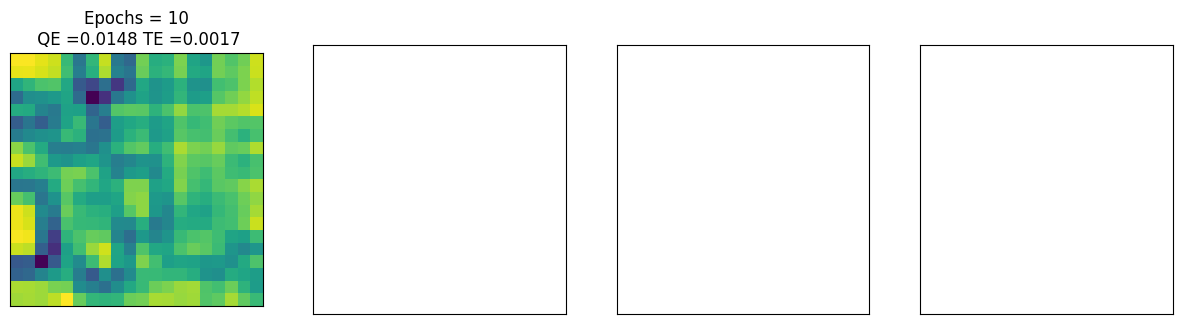

<Figure size 1000x500 with 0 Axes>

In [ ]:
# # Initialize SOM grid dimensions
# m = 20
# n = 20

# # Initialize training data
# train_data = tfidf_matrix_reduced

# # Initialize SOM grid with random weights
# SOM = np.random.rand(m, n, train_data[0].shape[0])

# epochs = 100
# fig, ax = plt.subplots(
#     nrows=1, ncols=4, figsize=(15, 3.5),
#     subplot_kw=dict(xticks=[], yticks=[]))
# total_epochs = 0
# SOMS = []
# QE_values = []
# TE_values = []

# # Convert train_data to numpy array
# train_data_array = np.array(train_data)

# for epochs_per_iter, i in zip([10], range(1)):
#     total_epochs += epochs_per_iter
#     num_sentences = len(train_data_array)  # Number of sentences in the dataset
#     random_indices = np.random.choice(num_sentences, size=10000, replace=False)
#     train_data_subset = train_data_array[random_indices]
#     SOM = train_SOM(SOM, train_data_subset, learn_rate=0.1, radius_sq=12, epochs=epochs_per_iter)
#     SOMS.append(SOM)
#     QE = round(calculateQE(SOM, train_data_subset), 4)
#     TE = round(calculateTE(SOM, train_data_subset), 4)
#     QE_values.append(QE)
#     TE_values.append(TE)

#     ax[i].imshow(u_matrix(SOM))
#     ax[i].title.set_text('Epochs = ' + str(total_epochs) + '\n QE =' + str(QE) + ' TE =' + str(TE))

# # Plotting QE and TE values
# plt.figure(figsize=(10, 5))

In [12]:
with open('trained_SOM.obj', 'rb') as pickleFile:
    SOM = pickle. load(pickleFile)

In [13]:
u_matrix_values = u_matrix(SOM)

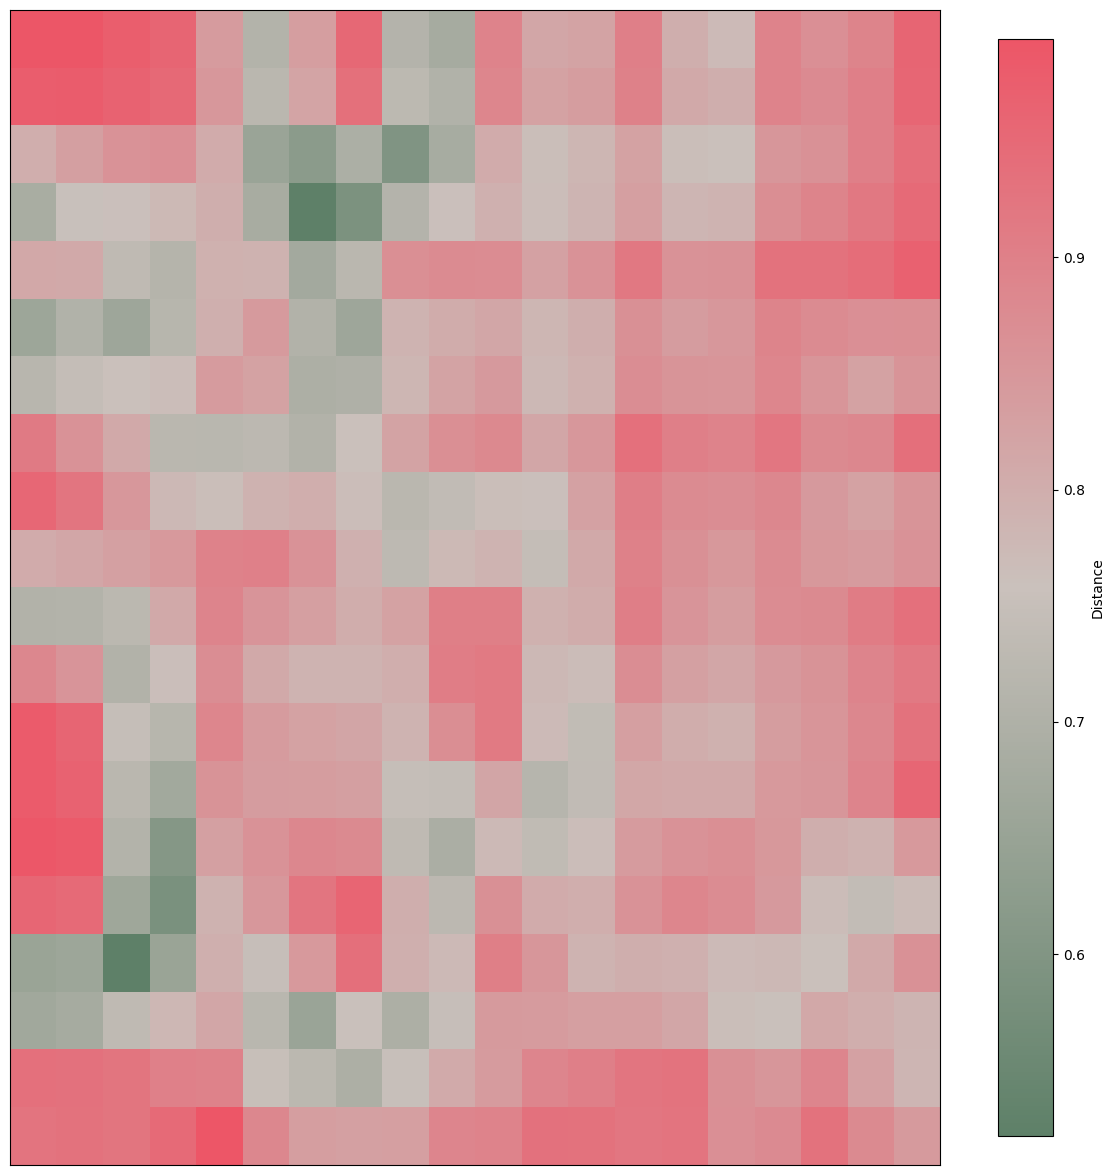

In [14]:
plt.figure(figsize=(15, 15))
colors = [(0, "#5E8068"), (.5, "#CAC1BC"), (1, "#ED5667")] # "#ED5667"), (.5, "#CAC1BC"), (1, "#5E8068",,,, (0, "#5673ed"), (.5, "#bdb9ca"), (1, "#80655e")
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
im = plt.imshow(u_matrix_values, cmap=cmap, aspect='auto')
# plt.title(f'U-Matrix\n σ= {0.3}, η = {4},\n QE = {QE}, TE = {TE}')
plt.colorbar(im, shrink=0.95, label='Distance')
plt.xticks([])
plt.yticks([])
plt.show()

In [15]:
vectors = tfidf_matrix_reduced
train_data = tfidf_matrix_reduced

In [16]:
with open('neuron_sentence_mapping.obj', 'rb') as pickleFile:
    neuron_sentence_mapping = pickle. load(pickleFile)

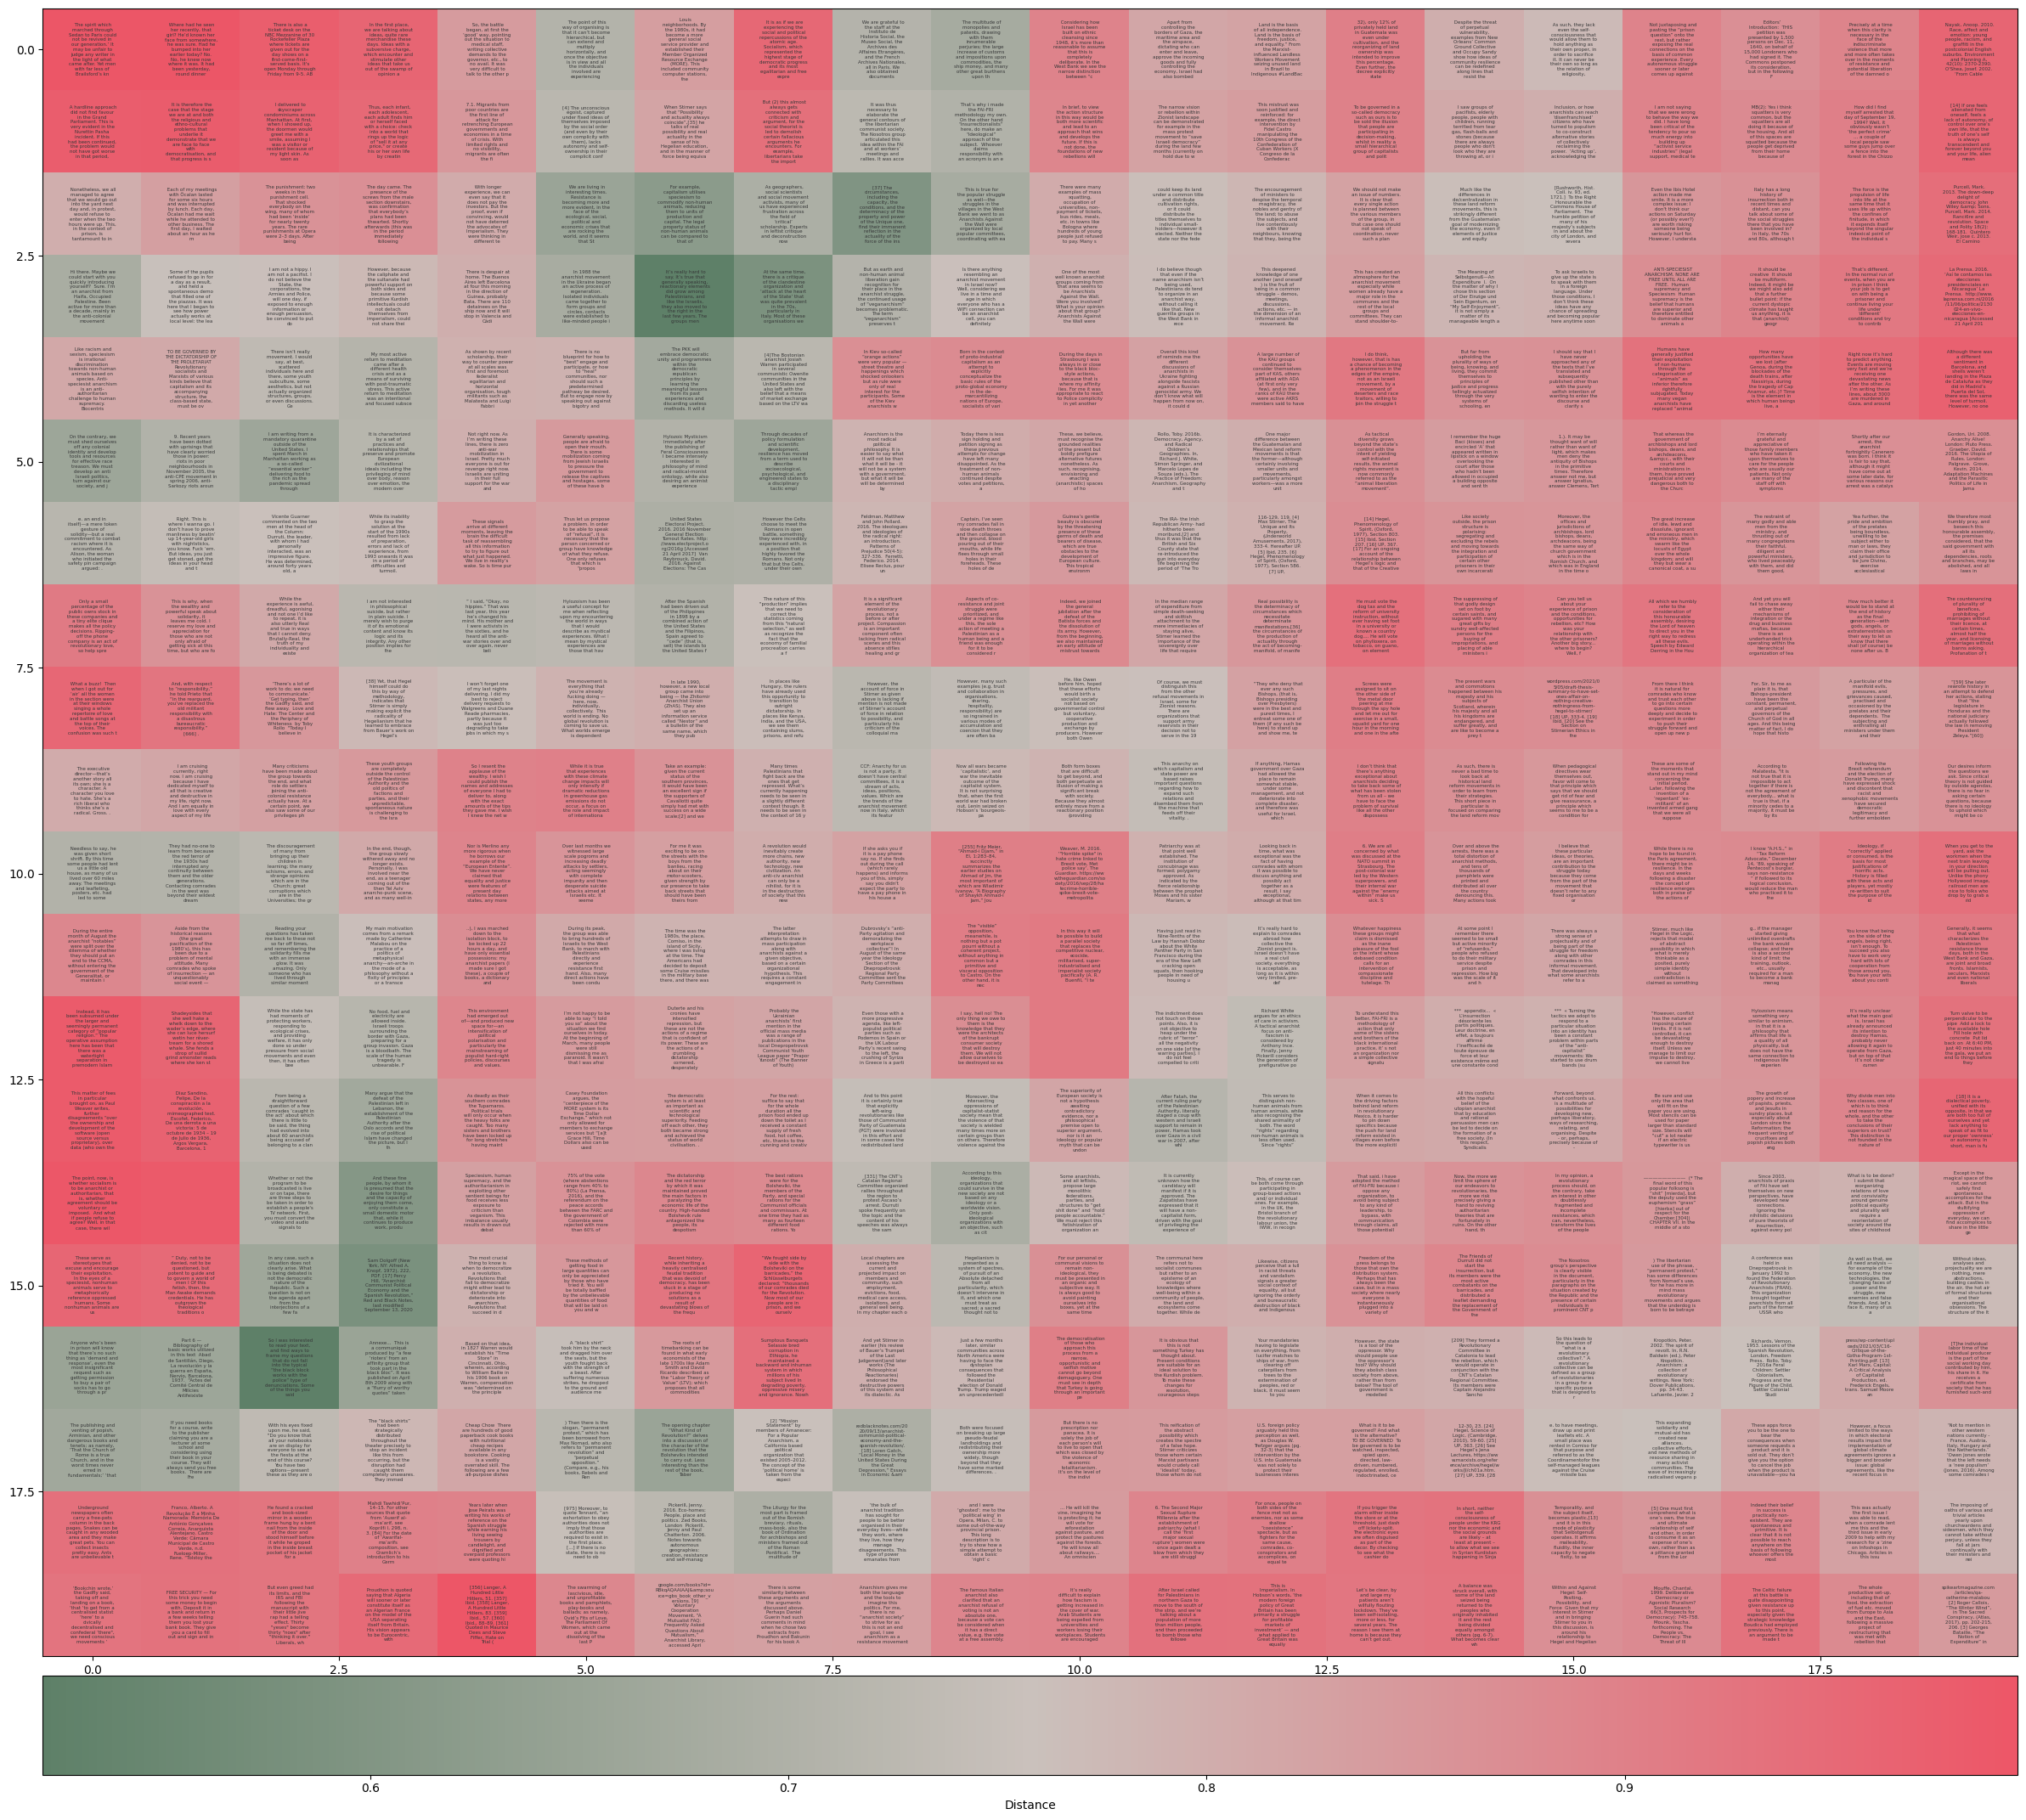

In [17]:
import textwrap

# Plot the U-Matrix and display the mapped sentences for each neuron
plt.figure(figsize=(30, 30))
im = plt.imshow(u_matrix_values, cmap=cmap, aspect='auto')
# plt.title(f'U-Matrix\n σ= {0.3}, η = {4},\n QE = {QE}, TE = {TE}')
plt.colorbar(im, orientation='horizontal', label='Distance', pad=0.01)

# Display only the first 100 characters of each sentence in each grid cell
for (i, j), sentences in neuron_sentence_mapping.items():
    if sentences:  # Check if there are sentences associated with the neuron
        # Reduce font size
        fontsize = 4
        # Select the first sentence associated with the neuron
        sentence = sentences[0][:200]  # Take the first 100 characters
        # Wrap the sentence to fit within the grid cell
        wrapped_sentence = "\n".join(textwrap.wrap(sentence, width=20))
        plt.text(j, i, wrapped_sentence, ha='center', va='center', color='#353637', fontsize=fontsize)

# plt.savefig('SOM_Strike.pdf', format='pdf')

# Show the plot
plt.show()

# Activate the SOM

In [24]:
query_sentences = "The cat slept peacefully on the windowsill"
query_vectors = vectorizer_tfidf.transform([query_sentences])
query_vectors

<1x19666 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [25]:
# Initialize the Truncated SVD with n_components=300
svd = TruncatedSVD(n_components=600)

# Fit and transform the TF-IDF matrix
tfidf_reduced = svd.fit_transform(tfidf_matrix)

# Now, transform the query vector using the same SVD transformation
query_reduced = svd.transform(query_vectors)

In [26]:
print(train_data.shape)
print(SOM.shape)
print(query_reduced.shape)

(100000, 600)
(20, 20, 600)
(1, 600)


In [27]:
activated_SOM = activate(train_data, SOM, query_reduced[0])

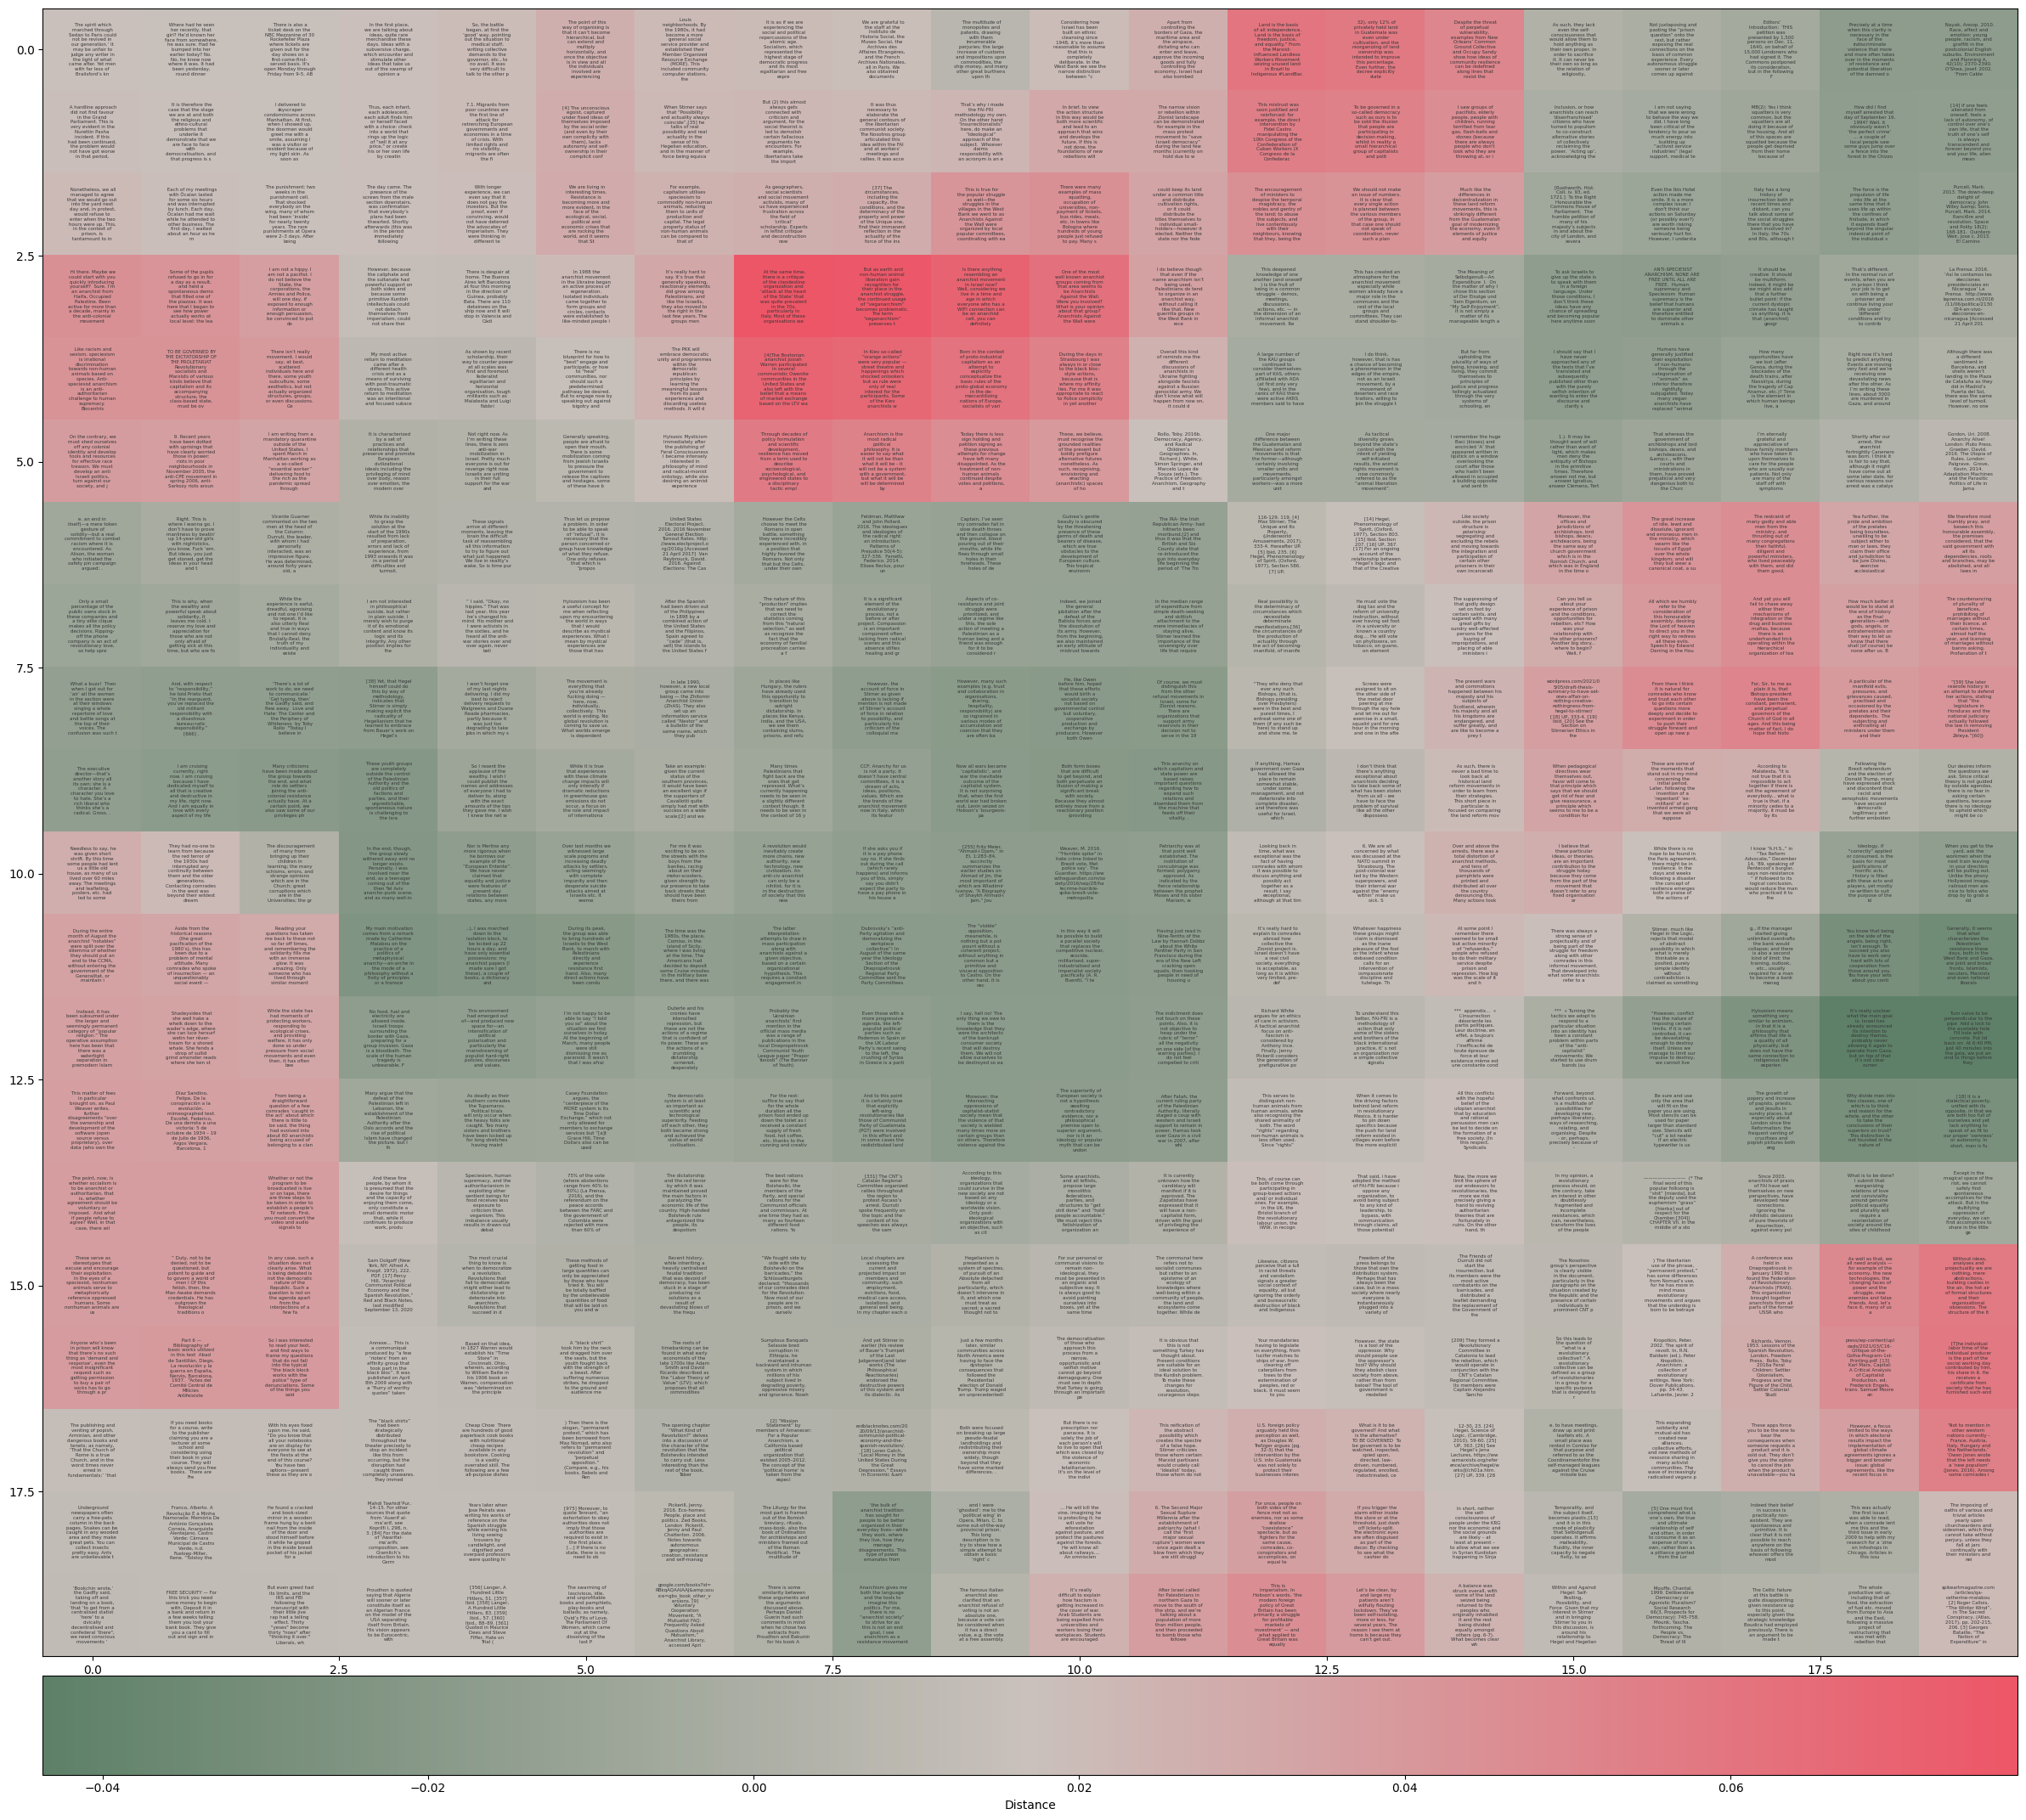

In [28]:
import textwrap

# Plot the U-Matrix and display the mapped sentences for each neuron
plt.figure(figsize=(30, 30))
im = plt.imshow(activated_SOM, cmap=cmap, aspect='auto')
# plt.title(f'U-Matrix\n σ= {0.3}, η = {4},\n QE = {QE}, TE = {TE}')
plt.colorbar(im, orientation='horizontal', label='Distance', pad=0.01)

# Display only the first 100 characters of each sentence in each grid cell
for (i, j), sentences in neuron_sentence_mapping.items():
    if sentences:  # Check if there are sentences associated with the neuron
        # Reduce font size
        fontsize = 4
        # Select the first sentence associated with the neuron
        sentence = sentences[0][:200]  # Take the first 100 characters
        # Wrap the sentence to fit within the grid cell
        wrapped_sentence = "\n".join(textwrap.wrap(sentence, width=20))
        plt.text(j, i, wrapped_sentence, ha='center', va='center', color='#353637', fontsize=fontsize)

plt.savefig('SOM_TFIDF_Activated02.pdf', format='pdf')

# Show the plot
plt.show()

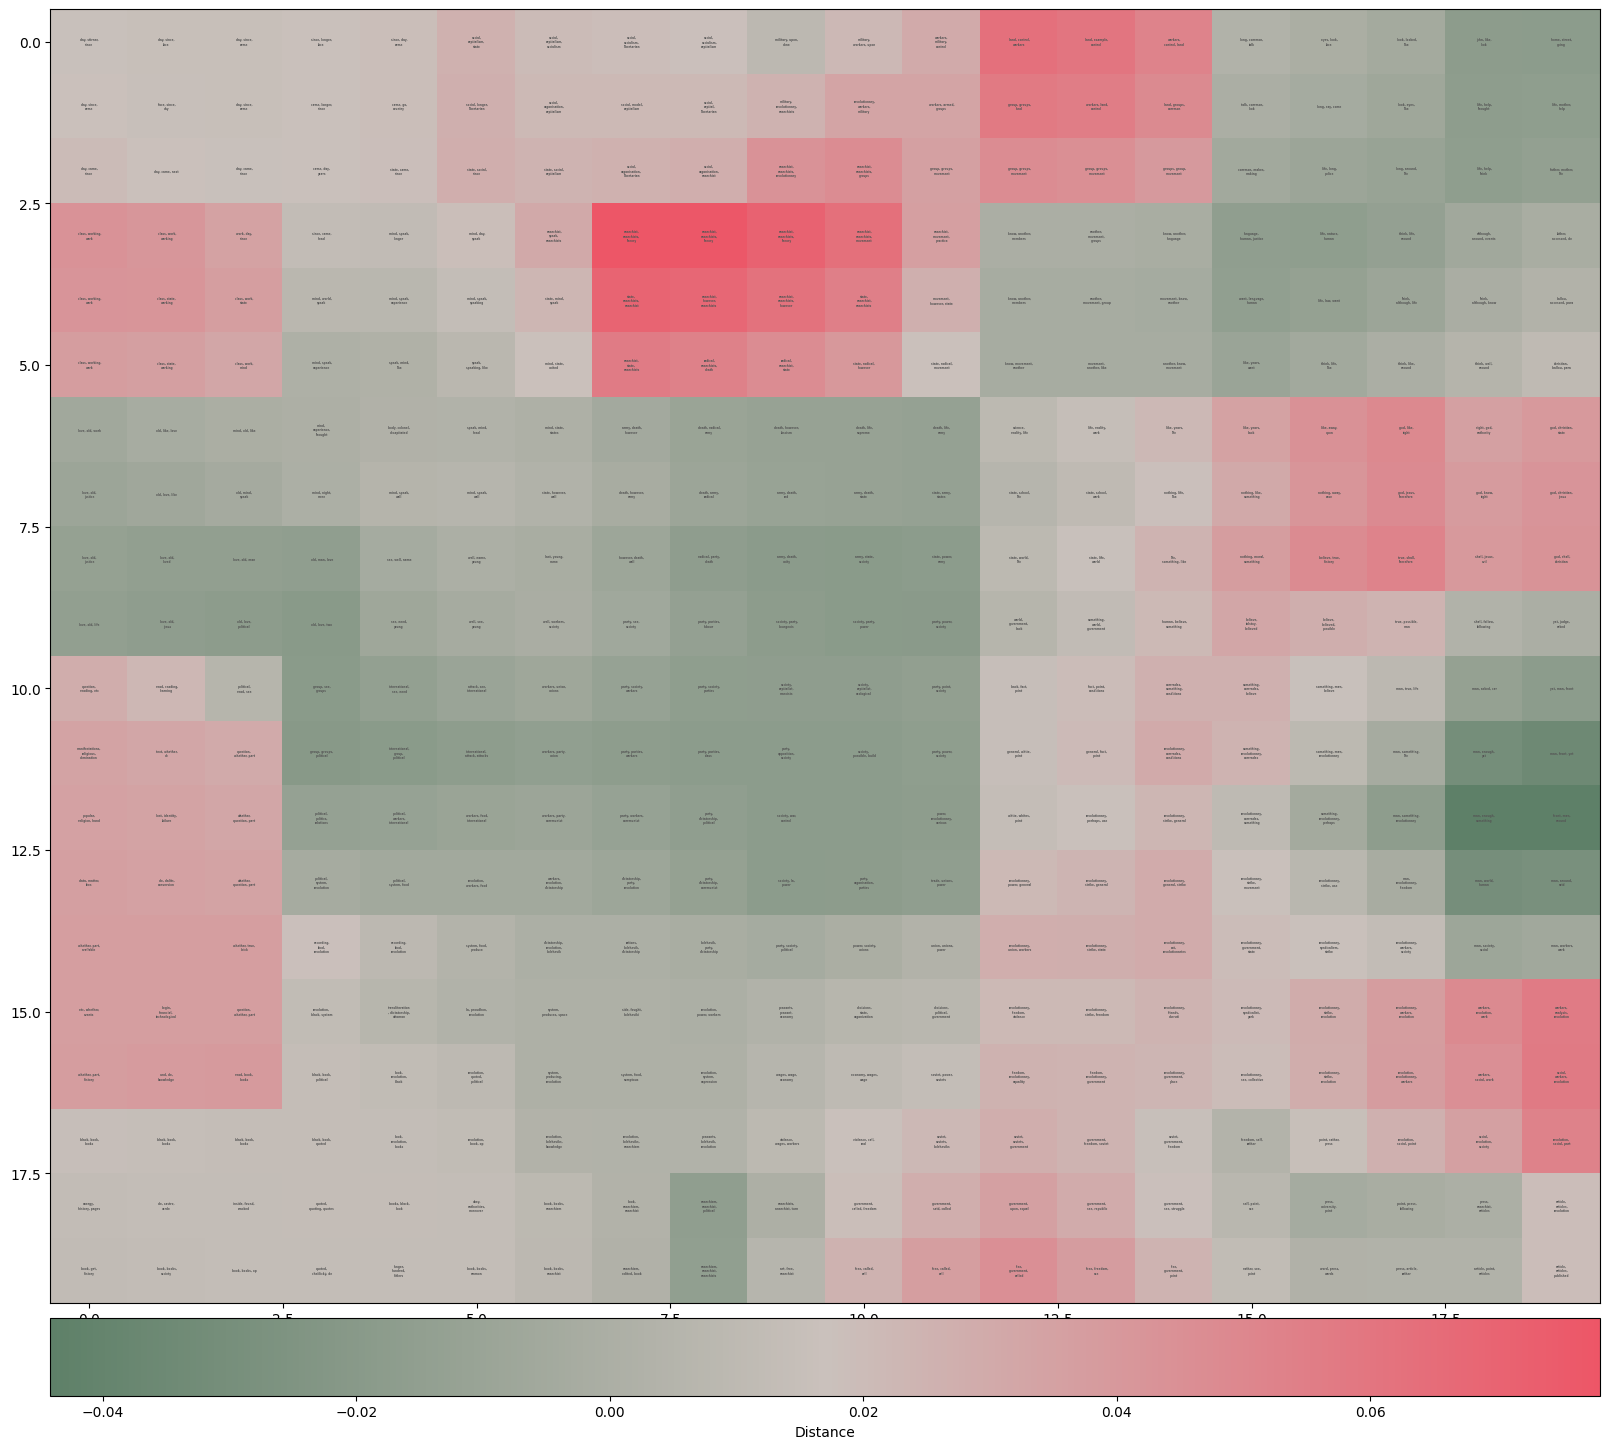

In [41]:
import textwrap

# Plot the U-Matrix and display the mapped sentences for each neuron
plt.figure(figsize=(20, 20))
im = plt.imshow(activated_SOM, cmap=cmap, aspect='auto')
# plt.title(f'U-Matrix\n σ= {0.3}, η = {4},\n QE = {QE}, TE = {TE}')
plt.colorbar(im, orientation='horizontal', label='Distance', pad=0.01)

# Display first 6 common concepts for each grid cell
for (i, j), neuron in neuron_sentence_mapping.items():
    # Reduce font size
    fontsize = 2
    # Initialize an empty list to store common concepts
    common_concepts = []
    concepts = find_common_concepts(neuron_sentence_mapping[(i,j)])
    # Iterate through the sentences mapped to the neuron
    # print(i,j)
    # for neuron_sentence_mapping in enumerate(neuron):
    #     # print(k)
    #     # Find concepts in the sentence and add them to the common concepts list
    # concepts = find_common_concepts(sentence)
    common_concepts.extend(concepts)

    # print(common_concepts)
    # Take the first 6 common concepts

    first_6_common_concepts = ", ".join(common_concepts[:3])
    wrapped_text = textwrap.fill(first_6_common_concepts, width=15)

    plt.text(j, i, wrapped_text, ha='center', va='center', color='#555555', fontsize=fontsize, fontname='Helvetica', fontweight='bold')

    # num_sentences = len(neuron)
    # margin = 0.15  # Adjust the margin as needed
    # plt.text(j-0.5+margin, i-0.5+margin, f'{num_sentences}', ha='center', va='center', color='#555555', fontsize=fontsize, fontname='Helvetica')

# plt.savefig('SOM_RightToStrike.pdf', format='pdf')

# Show the plot
plt.show()